In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import os, gc, logging, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#import cudf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import mode
from tqdm.notebook import tqdm

# Intel® Extension for Scikit-learn installation:
!pip install scikit-learn-intelex
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans, OPTICS
from pathlib import Path

from sklearnex import patch_sklearn
patch_sklearn()


import tensorflow as tf
warnings.filterwarnings("ignore")

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

## Some of the Kagglers has mentioned good increase in LB score when scaling is applied. In this notebook, various scaling techniques and their effect on the LB board is presented.

The following techniques are used to prepare the model

1) Clustering using variuous techninques

2) 10 fold StratifiedKFold technique for CV

3) sample_weight technique to capture the repeated rows

4) ExtraTreesClassifier 

Full details of model development can be found in my other notebook
https://www.kaggle.com/abdulravoofshaik/its-all-about-clustering-lb-98-34

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-feb-2022/train.csv').set_index("row_id")
test = pd.read_csv('../input/tabular-playground-series-feb-2022/test.csv').set_index("row_id")

#sample_submission = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")

#train = train.to_pandas()
#test = test.to_pandas()

feature_cols = test.columns.tolist()

le = LabelEncoder()
train["target"] = le.fit_transform(train["target"])

for col in feature_cols:
    train[col] = train[col].astype("float32")
    test[col] = test[col].astype("float32")
le.inverse_transform(train["target"] )
# Create a new dataframe without duplicates, but with an additional sample_weight column
vc = train.value_counts()
dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns=train.columns)
dedup_train2 = pd.DataFrame([list(tup) for tup in vc.index.values], columns=train.columns)
dedup_train2['sample_weight'] = vc.values
from sklearn.preprocessing import LabelEncoder
TARGET = train.columns.difference(test.columns)[0]
features = dedup_train.columns[dedup_train.columns != TARGET]
# Encoding categorical features
le2 = LabelEncoder()

X_train = dedup_train[features]
y_train = pd.DataFrame(le2.fit_transform(dedup_train[TARGET]), columns=[TARGET])
sample_weight = dedup_train2['sample_weight']
X=dedup_train[feature_cols]
y=dedup_train["target"]
n_components = 2

tf.random.set_seed(42)
KI = tf.keras.initializers.glorot_uniform(seed=42)

encoder_input = tf.keras.layers.Input(shape=(dedup_train[features].shape[1],), name="Input")
encoder_x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI, name="Encoder")(encoder_input)
encoder_output = tf.keras.layers.Dense(n_components, activation="swish", kernel_initializer=KI, name="Bottleneck")(encoder_x)

decoder_x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI, name="Decoder")(encoder_output)
decoder_output = tf.keras.layers.Dense(dedup_train[features].shape[1], kernel_initializer=KI, name="Output")(decoder_x)

encoder = tf.keras.Model(encoder_input, encoder_output)
autoencoder = tf.keras.Model(encoder_input, decoder_output)

autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(dedup_train[features], dedup_train[features], epochs=5)
tf.keras.utils.plot_model(autoencoder, show_shapes=True, rankdir="LR")
feature_cols = test.columns.tolist()
enc_x = encoder.predict(dedup_train[features])
enc_t = encoder.predict(test[features])

enc_cols = []
for i in range(n_components):
    col = f"ENC{i+1}"
    dedup_train[col] = enc_x[:,i]
    dedup_train[col] = enc_x[:,i]
    test[col] = enc_t[:,i]
    test[col] = enc_t[:,i]
    enc_cols.append(col)

del autoencoder, encoder, history, enc_x, enc_t
gc.collect()

df_x = dedup_train[["ENC1", "ENC2", "target"]].copy()
df_x["target"] = le.inverse_transform(df_x["target"])
df_t = test[["ENC1", "ENC2"]].copy()
gc.collect()
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000, n_init=100)

df_x["cluster"] = kmeans.fit_predict(dedup_train[enc_cols])
df_t["cluster"] = kmeans.predict(test[enc_cols])
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(dedup_train[feature_cols])
T_pca = pca.transform(test[feature_cols])

pca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]

X_pca = pd.DataFrame(X_pca, columns=pca_cols, index=dedup_train.index)
T_pca = pd.DataFrame(T_pca, columns=pca_cols, index=test.index)

dedup_train = pd.concat([dedup_train, X_pca], axis=1)
test = pd.concat([test, T_pca], axis=1)

del pca, X_pca, T_pca
lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
X_lda = lda.fit_transform(dedup_train[feature_cols], dedup_train["target"])
T_lda = lda.transform(test[feature_cols])

lda_cols = [f"LDA{i+1}" for i in range(X_lda.shape[1])]

X_lda = pd.DataFrame(X_lda, columns=lda_cols, index=dedup_train.index)
T_lda = pd.DataFrame(T_lda, columns=lda_cols, index=test.index)

dedup_train = pd.concat([dedup_train, X_lda], axis=1)
test = pd.concat([test, T_lda], axis=1)

del lda, X_lda, T_lda
gc.collect()
svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42)

X_svd = svd.fit_transform(dedup_train[feature_cols])
T_svd = svd.transform(test[feature_cols])

svd_cols = [f"SVD{i+1}" for i in range(X_svd.shape[1])]

X_svd = pd.DataFrame(X_svd, columns=svd_cols, index=dedup_train.index)
T_svd = pd.DataFrame(T_svd, columns=svd_cols, index=test.index)

dedup_train = pd.concat([dedup_train, X_svd], axis=1)
test = pd.concat([test, T_svd], axis=1)

del svd, X_svd, T_svd, 
gc.collect()
# little bit of cleaning
feature_cols += enc_cols
feature_cols += pca_cols
feature_cols += svd_cols
dedup_train['sample_weight']=dedup_train2['sample_weight'].values
#As we can see we have included several additional columns which has the clustering information.
X=dedup_train[feature_cols]
y=dedup_train["target"]
X = pd.DataFrame(X, columns = feature_cols)


## Technique-1: Appply MinMaxScaler for both training and testing dataset

In [ ]:
# Use scaler of choice; here Standard scaler is used
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X.values)
X_scaled = scaler.transform(X.values)
X_scaled_df=pd.DataFrame(X_scaled, columns = feature_cols)

In [ ]:
test_scaled = scaler.transform(test[feature_cols].values)
test_scaled_df=pd.DataFrame(test_scaled, columns = feature_cols)

In [ ]:
N_SPLITS = 10
folds = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)
y_pred_list, y_proba_list, scores = [], [], []

for fold, (train_id, valid_id) in enumerate(tqdm(folds.split(X_scaled_df, y), total=N_SPLITS)):
    print('####### Fold: ', fold)
    
    # Splitting
    X_train, y_train, sample_weight_train = X_scaled_df.iloc[train_id], y.iloc[train_id], sample_weight.iloc[train_id]
    X_valid, y_valid, sample_weight_valid = X_scaled_df.iloc[valid_id], y.iloc[valid_id], sample_weight.iloc[valid_id]
    # Model
    model = ExtraTreesClassifier(
        n_estimators=1000,
        n_jobs=-1,
        verbose=0,
        random_state=1
    )

    # Training
    model.fit(X_train, y_train)
        
    # Validation
    valid_pred = model.predict(X_valid)
    valid_score = accuracy_score(y_valid, valid_pred)
    print(f'Accuracy score: {valid_score:5f}\n')
    scores.append(valid_score)
        # Prediction for submission
    y_pred_list.append(model.predict(test_scaled_df))
    y_proba_list.append(model.predict_proba(test_scaled_df))
    # Prediction for submission
    #y_pred_list.append(np.argmax(model.predict(test[feature_cols])))
    #y_proba_list.append(np.argmax(model.predict_proba(test[feature_cols])))
    #y_pred_list.append(model.predict(test[feature_cols]))
    #y_proba_list.append(model.predict_proba(predict(test[feature_cols])))
    
score = np.array(scores).mean()
print(f'Mean accuracy score: {score:6f}')

In [ ]:
# Majority vote
y_pred = mode(y_pred_list).mode[0]
y_pred

In [ ]:
target_distrib = pd.DataFrame({
    'count': train.target.value_counts(),
    'share': train[TARGET].value_counts() / train.shape[0] * 100
})

target_distrib['pred_count'] = pd.Series(y_pred, index=test.index).value_counts()
target_distrib['pred_share'] = target_distrib['pred_count'] / len(test) * 100
target_distrib.sort_index()

In [ ]:
y_proba = sum(y_proba_list) / len(y_proba_list)
y_proba += np.array([0, 0, 0.012, 0.055, 0, 0, 0, 0, 0, 0])
y_pred_tuned = le.inverse_transform(np.argmax(y_proba, axis=1))
pd.Series(y_pred_tuned, index=test.index).value_counts().sort_index() / len(test) * 100


In [ ]:
submission = pd.read_csv('../input/tabular-playground-series-feb-2022/sample_submission.csv')
submission[TARGET] = y_pred_tuned
submission.to_csv('submission_MM.csv', index=False)
#submission

# LB score is 0.98438

This is not an improvement when compared previous notebook which has no scaling.

## Technique-2: Apply Standardscaler for both training and testing dataset
The same above code is applied to standardscaler also, code is not presented to avoid repetition. The screenshot of the outputs are as below: 


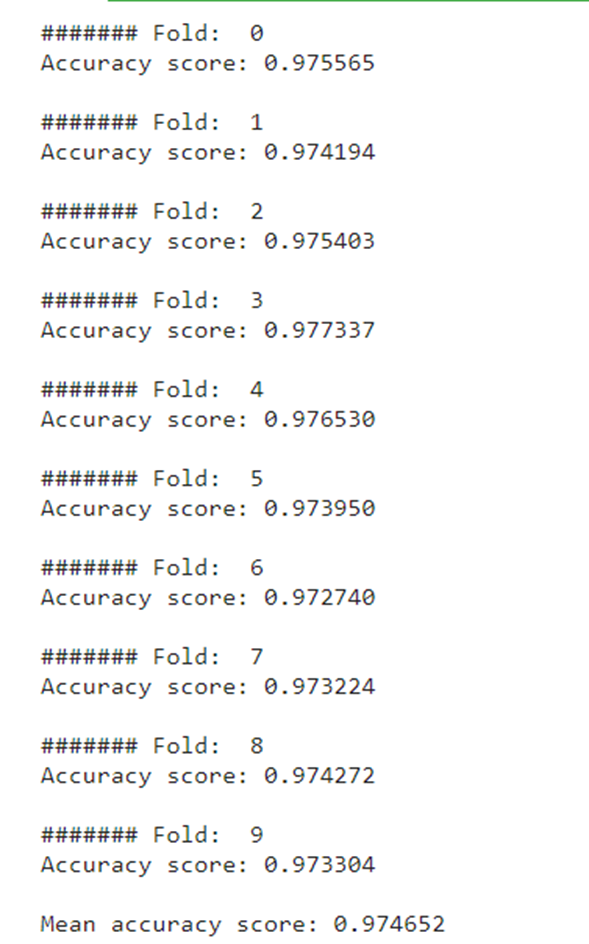


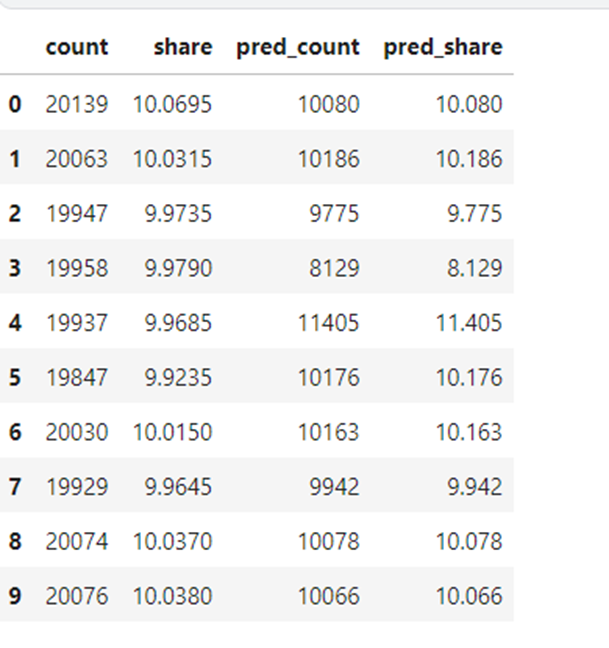



In [ ]:
submission = pd.read_csv('../input/tabular-playground-series-feb-2022/sample_submission.csv')
submission[TARGET] = y_pred_tuned
submission.to_csv('submission_SS.csv', index=False)
#submission

## The LB score is 0.98378
This is not an improvement from previous notebook without scaling.

## Technique-3: Apply RobustScaler for both training and testing dataset


In [ ]:
submission[TARGET] = y_pred_tuned
submission.to_csv('submission_RB.csv', index=False)
#submission

# The LB score is 0.9839

This is not an improvement when compared previous notebook which has no scaling.

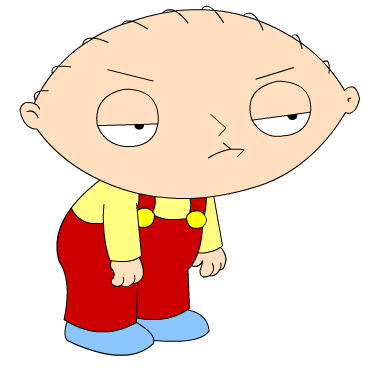

# ***The summary is Scaling does not increase LB in this dataset.***
## Dont forget to upvote if you find this notebook useful

References:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

https://www.deviantart.com/happenstance67/art/Stewie-26557138